In [127]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.transforms.functional as TF
import wandb
import wandb_util.wandb_util as wbu

torch.set_grad_enabled(False)

api = wandb.Api()
run = api.run("diffusion-3D-features/jx80zf65")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


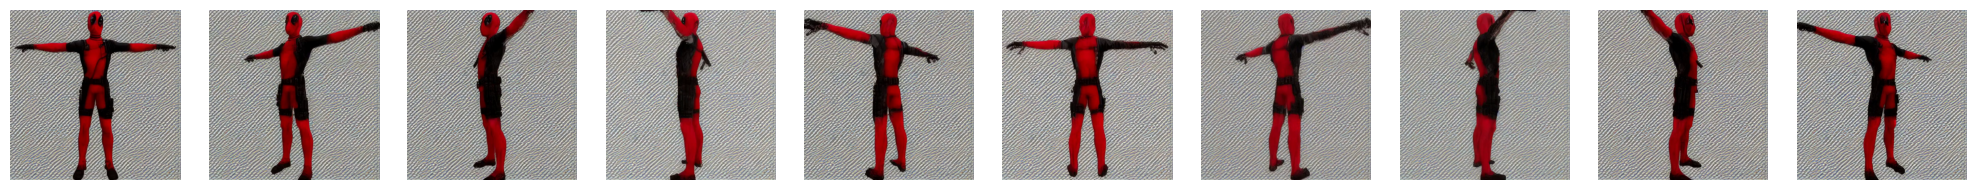

torch.Size([10, 3, 512, 512])

In [128]:
from text3d2video.artifacts.video_artifact import VideoArtifact
from text3d2video.utilities.ipython_utils import display_ims

aggr = wbu.logged_artifacts(run, type="video", name_startswith="aggr")[0]
aggr = VideoArtifact.from_wandb_artifact(aggr)

frames = aggr.get_frames()[0:-1]
feature_maps = [TF.to_tensor(frame) for frame in frames]
feature_maps = torch.stack(feature_maps)

display_ims(frames)
feature_maps.shape

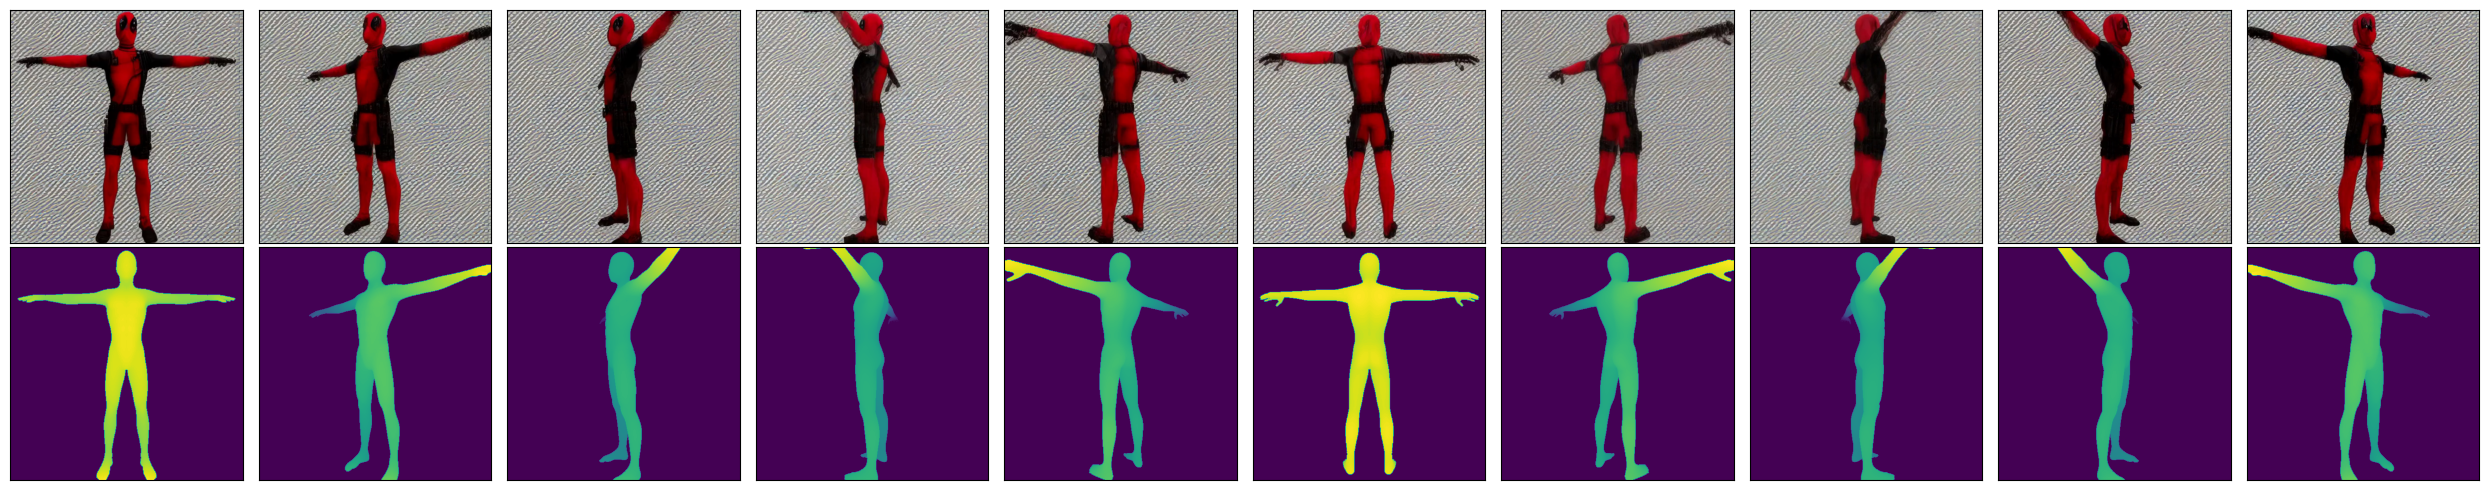

In [129]:
import numpy as np
from pytorch3d.renderer import FoVPerspectiveCameras
from pytorch3d.io import load_objs_as_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.ipython_utils import display_ims_grid

# TODO replace from reading artifact, here we have prior knowledge
device = "cuda"
angles = np.linspace(0, 360, len(frames), endpoint=False)
R, T = turntable_extrinsics(angles=angles, dists=1.5)
aggr_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=65)
mesh_path = "data/meshes/mixamo-human.obj"
mesh = load_objs_as_meshes([mesh_path], device=device)
aggr_meshes = mesh.extend(len(aggr_cams))

depths = render_depth_map(aggr_meshes, aggr_cams)
display_ims_grid([frames, depths])

In [137]:
from text3d2video.backprojection import project_visible_verts_to_cameras

vert_xys, vert_indices = project_visible_verts_to_cameras(
    aggr_meshes, aggr_cams, res=100
)

In [138]:
from text3d2video.backprojection import aggregate_features_precomputed_vertex_positions
from pytorch3d.renderer import TexturesVertex

vert_features = aggregate_features_precomputed_vertex_positions(
    feature_maps.cuda(),
    aggr_meshes.num_verts_per_mesh()[0],
    vert_xys,
    vert_indices,
)

texture = TexturesVertex(vert_features.unsqueeze(0))

In [139]:
from text3d2video.utilities.ipython_utils import display_vid, render_texture_360

display_vid(render_texture_360(mesh, texture), resolution=512)